# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [78]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import math
import json
import pickle as pkl
import datetime
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from hyperopt import hp, tpe, fmin, Trials, space_eval
from functools import partial
%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [89]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [5]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


## Data Clean for each individual table

### portfolio

In [3]:
# change id --> offer_id
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

# break down channels to one-hot-encoding columns
channels = portfolio['channels'].tolist()
channels_set = set([item for sublist in channels for item in sublist]) # get unique channel types
for c in channels_set:
    portfolio['channel_'+c] = 0
# if channels column has the channel, channel_[channel_type] = 1. Otherwise 0
for i, row in portfolio.iterrows():
    for c in channels_set:
        if c in row['channels']:
            portfolio['channel_'+c].iloc[i] = 1
        else:
            portfolio['channel_'+c].iloc[i] = 0
del portfolio['channels']
portfolio.head()

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,difficulty,duration,offer_id,offer_type,reward,channel_email,channel_social,channel_web,channel_mobile
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,0,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,0,1,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,1,0


### profile

In [4]:
# change id --> customer_id
profile.rename(columns={'id': 'customer_id'}, inplace=True)

In [14]:
profile.head()

,age,became_member_on,gender,customer_id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


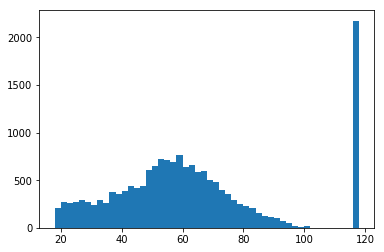

In [16]:
pyplot.hist(profile['age'], bins=50);

### transcript

In [92]:
# explore transcript
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [93]:
# explore transcript
transcript.value.apply(lambda x: list(x.keys())[0]).unique()

array(['offer id', 'amount', 'offer_id'], dtype=object)

In [95]:
# explore transcript
transcript[transcript['event'] == 'transaction'].head()

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [5]:
# change person --> customer_id
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

# break value --> offer_id, amount, rewards
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
del transcript['value']

In [6]:
# merge offer id with offer_id
transcript['offer_id'] = transcript['offer_id'].fillna(transcript['offer id'])

In [ ]:
transcript.head()

In [11]:
pd.DataFrame(transcript['event'].value_counts()).reset_index()

,index,event
0,transaction,138953
1,offer received,76277
2,offer viewed,57725
3,offer completed,33579


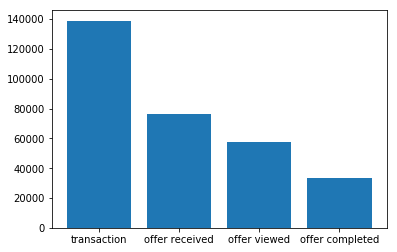

In [14]:
pyplot.bar(transcript['event'].value_counts().index, transcript['event'].value_counts());

## Create target

In [15]:
# merge transcript with profile and portolio
df = transcript.merge(profile, how='left', on='customer_id')
df = transcript.merge(portfolio, how='left', on='offer_id')
df.head()

,event,customer_id,time,offer id,amount,offer_id,reward_x,difficulty,duration,offer_type,reward_y,channel_email,channel_social,channel_web,channel_mobile
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,7.0,bogo,5.0,1.0,0.0,1.0,1.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,20.0,10.0,discount,5.0,1.0,0.0,1.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,10.0,7.0,discount,2.0,1.0,0.0,1.0,1.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0


In [16]:
# drop unnecessary columns
df = df.drop(columns=['reward_x','reward_y', 'offer id'])

In [28]:
df.groupby(['event','offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

There are 4 types of events: offer completed, offer received, offer viewed and transaction. But the data shows that we do not have any offer_id associated with transactions, because they are not recorded in the transcript event data. 

An offer conversion is defined as follows:

For a BOGO and discount offer: offer received -> offer viewed -> transaction -> offer completed

For an informational offer: offer received -> offer viewed -> transaction

In [17]:
# sort events by customer_id and time for customer action
df = df.sort_values(['customer_id','time'])

In [18]:
# filter dataset for transactions that occur after an offer is viewed, forward fill offer ids by customer
offers_view_transacted = df[['time','offer_id','customer_id','event']][(df['event']=='transaction') | (df['event']=='offer viewed')].groupby(['customer_id','offer_id']).ffill()
offers_view_transacted['offer_id'] = offers_view_transacted['offer_id'].ffill()

# merge with df to fill offer_id na in df
df = df.merge(offers_view_transacted,how='left',on=['customer_id','time','event'])


In [19]:
df['offer_id'] = df['offer_id_x'].fillna(df['offer_id_y'])
df.drop(columns=['offer_id_x','offer_id_y'], inplace=True)
df.head()

,event,customer_id,time,amount,difficulty,duration,offer_type,channel_email,channel_social,channel_web,channel_mobile,offer_id
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,0.0,3.0,informational,1.0,1.0,0.0,1.0,5a8bc65990b245e5a138643cd4eb9837
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,0.0,3.0,informational,1.0,1.0,0.0,1.0,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,0.0,4.0,informational,1.0,0.0,1.0,1.0,3f207df678b143eea3cee63160fa8bed
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,0.0,4.0,informational,1.0,0.0,1.0,1.0,3f207df678b143eea3cee63160fa8bed


In [20]:
# for columns in portfolio, fill the na values by the updated offer_id
df = df[['event','customer_id','time','amount','offer_id']].merge(portfolio, how='left', on='offer_id')

In [21]:
df = df.sort_values(['customer_id','offer_id','time'])
df.head()

,event,customer_id,time,amount,offer_id,difficulty,duration,offer_type,reward,channel_email,channel_social,channel_web,channel_mobile
14,offer received,0009655768c64bdeb2e877511632db8f,576,NaN,2906b810c7d4411798c6938adc9daaa5,10,7,discount,2,1,0,1,1
16,offer completed,0009655768c64bdeb2e877511632db8f,576,NaN,2906b810c7d4411798c6938adc9daaa5,10,7,discount,2,1,0,1,1
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,3f207df678b143eea3cee63160fa8bed,0,4,informational,0,1,0,1,1
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,3f207df678b143eea3cee63160fa8bed,0,4,informational,0,1,0,1,1
6,transaction,0009655768c64bdeb2e877511632db8f,414,8.57,3f207df678b143eea3cee63160fa8bed,0,4,informational,0,1,0,1,1


In [22]:
# splite df into bogo/discount and informational
df_bogo_discount = df[df['offer_type'].isin(['bogo','discount'])].reset_index(drop=True)
df_bogo_discount = df_bogo_discount.sort_values(['customer_id','offer_id','time'])

df_informational = df[df['offer_type']=='informational'].reset_index(drop=True)
df_informational = df_informational.sort_values(['customer_id','offer_id','time'])

In [23]:
def get_target(data, conversion_action):
    """ 
    Get target - effective offer conversion. If offer is not received, it will be deleted from the dataframe because we are only interested in offers received by the customers.
    INPUT:
        dataframe: Pandas DataFrame
        conversion_action: str
            - bogo/discount: 'offer completed'
            - informational: 'transaction'
    OUTPUT:
        dataframe: Pandas DataFrame
            dataframe with target assigned
    """
    
    valid_offer_id = []
    valid_customer_id = []
    valid_offer_time = []
    valid_offer_type = []
    
    offers = data[data.event=='offer received']
    offers = offers.groupby(['offer_id', 'time','duration','offer_type']).size().reset_index()
    del offers[0]
    for i in range(len(offers)):
        off_id = offers.iloc[i]['offer_id'] # offer id
        start = offers.iloc[i]['time'] # time when this offer was received
        end = offers.iloc[i]['duration'] + start # end-point of this offer 

        # offers within valid period
        valid = data[(data.time>=start)&(data.time<=end)&(data.offer_id==off_id)]

        # for each customer, if offer viewed and completed are in valid period & viewed is before completed, record information
        for c in valid['customer_id'].unique():
            valid_event = valid[valid['customer_id'] == c]['event'].tolist()
            if ('offer viewed' in valid_event)&(conversion_action in valid_event):
                # find the last index of offer completed.
                last_idx_completed = len(valid_event) - 1 - valid_event[::-1].index(conversion_action)
                if 'offer viewed' in valid_event[:last_idx_completed]:
                    valid_offer_id.append(off_id)
                    valid_customer_id.append(c)
                    valid_offer_time.append(start)
                    valid_offer_type.append(offers.iloc[i]['offer_type'])
    # merge valid to df to create target
    valid_df = pd.DataFrame({'offer_id': valid_offer_id, 'customer_id': valid_customer_id, \
                         'time': valid_offer_time, 'offer_type': valid_offer_type, 'target': [1]*len(valid_offer_type)})
    
    data = data.merge(valid_df, how='left', on=['customer_id','offer_id','time','offer_type'])   
    
    # only keep rows with offer received. Otherwise, the rows are not in the scope of the project
    offer_eventlist = data.groupby(['offer_id','time','offer_type'])['event'].apply(list).reset_index()
    offer_eventlist['delete'] = offer_eventlist['event'].apply(lambda x: 0 if 'offer received' in x else 1)
    data = data.merge(offer_eventlist[['offer_id','time','offer_type','delete']], how='left', on=['offer_id','time','offer_type'])
    data = data[data['delete'] == 0]
    del data['delete']
    data['target'].fillna(0, inplace=True)
    
    return data

In [24]:
df_bogo_discount = get_target(df_bogo_discount, 'offer completed')
df_informational = get_target(df_informational, 'transaction')

In [25]:
# concate two sub dataframes together
df_target = pd.concat([df_bogo_discount, df_informational])
df_target.head()

,event,customer_id,time,amount,offer_id,difficulty,duration,offer_type,reward,channel_email,channel_social,channel_web,channel_mobile,target
0,offer received,0009655768c64bdeb2e877511632db8f,576,NaN,2906b810c7d4411798c6938adc9daaa5,10,7,discount,2,1,0,1,1,0.0
1,offer completed,0009655768c64bdeb2e877511632db8f,576,NaN,2906b810c7d4411798c6938adc9daaa5,10,7,discount,2,1,0,1,1,0.0
2,offer received,0009655768c64bdeb2e877511632db8f,408,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5,5,bogo,5,1,1,1,1,0.0
6,offer received,0009655768c64bdeb2e877511632db8f,504,NaN,fafdcd668e3743c1bb461111dcafc2a4,10,10,discount,2,1,1,1,1,0.0
10,transaction,0009655768c64bdeb2e877511632db8f,576,10.27,fafdcd668e3743c1bb461111dcafc2a4,10,10,discount,2,1,1,1,1,0.0


## Feature Engineering

In [26]:
# remove event column and then drop duplicates
df_target.drop(columns=['event','time','amount','offer_id'], inplace=True)
df_target.drop_duplicates(inplace=True)
df_target.head()

,customer_id,difficulty,duration,offer_type,reward,channel_email,channel_social,channel_web,channel_mobile,target
0,0009655768c64bdeb2e877511632db8f,10,7,discount,2,1,0,1,1,0.0
2,0009655768c64bdeb2e877511632db8f,5,5,bogo,5,1,1,1,1,0.0
6,0009655768c64bdeb2e877511632db8f,10,10,discount,2,1,1,1,1,0.0
14,00116118485d4dfda04fdbaba9a87b5c,5,5,bogo,5,1,1,1,1,0.0
21,0011e0d4e6b944f998e987f904e8c1e5,20,10,discount,5,1,0,1,0,0.0


In [27]:
# merge with profile table
df_target = df_target.merge(profile, how='left', on='customer_id')
df_target.head()

,customer_id,difficulty,duration,offer_type,reward,channel_email,channel_social,channel_web,channel_mobile,target,age,became_member_on,gender,income
0,0009655768c64bdeb2e877511632db8f,10,7,discount,2,1,0,1,1,0.0,33,20170421,M,72000.0
1,0009655768c64bdeb2e877511632db8f,5,5,bogo,5,1,1,1,1,0.0,33,20170421,M,72000.0
2,0009655768c64bdeb2e877511632db8f,10,10,discount,2,1,1,1,1,0.0,33,20170421,M,72000.0
3,00116118485d4dfda04fdbaba9a87b5c,5,5,bogo,5,1,1,1,1,0.0,118,20180425,None,NaN
4,0011e0d4e6b944f998e987f904e8c1e5,20,10,discount,5,1,0,1,0,0.0,40,20180109,O,57000.0


### convert became_member_on into member tenure

In [28]:
df_target['year'] = pd.Series([int(str(x)[:4]) for x in df_target['became_member_on']])
df_target['month'] = pd.Series([int(str(x)[-3]) for x in df_target['became_member_on']])
df_target['day'] = pd.Series([int(str(x)[-2:]) for x in df_target['became_member_on']])
df_target.loc[df_target['year'] == 2018, 'membership_tenure_days'] = (30*df_target['month'])+df_target['day']
df_target.loc[df_target['year'] != 2018, 'membership_tenure_days'] = ((2018-df_target['year'])*365)+(30*df_target['month'])+df_target['day']

df_target.drop(columns=['year','month','day','became_member_on'], inplace=True)


In [328]:
df_target.head()

,customer_id,difficulty,duration,offer_type,reward,channel_social,channel_mobile,channel_email,channel_web,target,age,gender,income,membership_tenure_days
0,0009655768c64bdeb2e877511632db8f,10,7,discount,2,0,1,1,1,0.0,33,M,72000.0,506.0
1,0009655768c64bdeb2e877511632db8f,5,5,bogo,5,1,1,1,1,0.0,33,M,72000.0,506.0
2,0009655768c64bdeb2e877511632db8f,10,10,discount,2,1,1,1,1,0.0,33,M,72000.0,506.0
3,00116118485d4dfda04fdbaba9a87b5c,5,5,bogo,5,1,1,1,1,0.0,118,None,NaN,145.0
4,0011e0d4e6b944f998e987f904e8c1e5,20,10,discount,5,0,0,1,1,0.0,40,O,57000.0,39.0


### one hot encoding for categorical features

In [29]:
df_target = pd.get_dummies(df_target, columns=['offer_type','gender'])
df_target.head()

,customer_id,difficulty,duration,reward,channel_email,channel_social,channel_web,channel_mobile,target,age,income,membership_tenure_days,offer_type_bogo,offer_type_discount,offer_type_informational,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,10,7,2,1,0,1,1,0.0,33,72000.0,506.0,0,1,0,0,1,0
1,0009655768c64bdeb2e877511632db8f,5,5,5,1,1,1,1,0.0,33,72000.0,506.0,1,0,0,0,1,0
2,0009655768c64bdeb2e877511632db8f,10,10,2,1,1,1,1,0.0,33,72000.0,506.0,0,1,0,0,1,0
3,00116118485d4dfda04fdbaba9a87b5c,5,5,5,1,1,1,1,0.0,118,NaN,145.0,1,0,0,0,0,0
4,0011e0d4e6b944f998e987f904e8c1e5,20,10,5,1,0,1,0,0.0,40,57000.0,39.0,0,1,0,0,0,1


## Modeling

In [35]:
# train/test split
X_train, X_test= train_test_split(df_target, test_size=0.2, random_state=7)
X_train.shape, X_test.shape

((51544, 18), (12887, 18))

### hyperopt search

In [60]:
hyper_params = {
    'max_depth': hp.choice('max_depth', range(3,6)),
    'learning_rate': hp.choice('learning_rate', [0.05, 0.1]),
    'n_estimators': hp.choice('n_estimators', range(10, 110, 30))
}

In [61]:
def evaluate(params, X, y):
    # Initilize instance of estimator
    clf = xgboost.XGBClassifier()
    # Set params
    clf.set_params(**params)
    # Calc CV score
    scores = cross_val_score(estimator=clf, X=X, y=y, 
                             scoring='roc_auc', cv=5)
    score = np.mean(scores)
    return score

# Objective minizmied 
hyperopt_objective = lambda params: (-1.0) * evaluate(params, X_train.drop(columns=['customer_id','target']), X_train['target'])


In [64]:
trials = Trials()
 
# Set algoritm parameters
algo = partial(tpe.suggest)
 
# Fit Tree Parzen Estimator
best_vals = fmin(hyperopt_objective, space=hyper_params,
                 algo=algo, max_evals=10, trials=trials,
                 rstate=np.random.RandomState(seed=2018))
 
# Print best parameters
best_params = space_eval(hyper_params, best_vals)
print("BEST PARAMETERS: " + str(best_params))
 
# Print best CV score
scores = [-trial['result']['loss'] for trial in trials.trials]
print("BEST CV SCORE: " + str(np.max(scores)))
 
# Print execution time
tdiff = trials.trials[-1]['book_time'] - trials.trials[0]['book_time']
print("ELAPSED TIME: " + str(tdiff.total_seconds() / 60))

100%|██████████| 10/10 [02:09<00:00, 15.92s/it, best loss: -0.7447956206053048]
BEST PARAMETERS: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 70}
BEST CV SCORE: 0.7447956206053048
ELAPSED TIME: 1.9315


In [74]:
# fit xgboost with best parameters
clf = xgboost.XGBClassifier()
clf.set_params(**best_params)
clf.fit(X_train.drop(columns=['customer_id','target']), X_train['target'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=70,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [76]:
y_pred_test = clf.predict_proba(X_test.drop(columns=['customer_id','target']))[:,1]

In [77]:
# auc
roc_auc_score(X_test['target'], y_pred_test)

0.7547407261757111

In [86]:
# get feature importance
fi = clf.get_booster().get_score(importance_type='gain')
fi

{'income': 8.585298071989579,
 'duration': 7.2425913972580656,
 'membership_tenure_days': 7.859653699070254,
 'channel_social': 10.711634570831324,
 'difficulty': 6.025356749343585,
 'offer_type_discount': 14.163447124074075,
 'age': 3.4392437516403507,
 'gender_M': 2.6151092532,
 'gender_O': 2.5246565343333334,
 'channel_web': 4.118742203111111,
 'gender_F': 4.640968992000001,
 'reward': 5.6894243950000005}

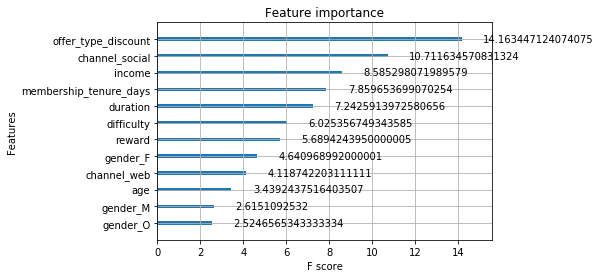

In [88]:
xgboost.plot_importance(clf, importance_type = 'gain')